## 2 Conservative Dynamics

### 2.1 Semi-analytic Equations of Motion

Import `rebound` and `celmech` packages as well as other libraries used:

In [1]:
import rebound as rb
import celmech as cm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import radvel
import pandas as pd
import reboundx

# make font bigger
plt.rc('font', size=16)

Import data:

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep =';')
hd_data.BJD -= 2.4e6

Params:

In [3]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

Get sim using least squares params:

In [4]:
def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim


Create sim from params:

In [5]:
time_base = np.median(hd_data.BJD)
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
cm.nbody_simulation_utilities.align_simulation(sim)

Construct Hamiltonian for the system:

In [6]:
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
pham.H

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

Now add eccentricity MMR terms (no inclination):

In [7]:
pham.add_MMR_terms(3, 1, max_order=3, inclinations=False)
pham.H

                                                                              
                                                                              
                                                                              
                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

                                                                              
                                                                              
                                                   

Now we want to compare $\theta_1$, $\theta_2$, $e_1$, $e_2$ and $P_2/P_1$ so we integrate over a series of times starting at $0$:

In [8]:
# inner and outer particles for rebound versus celmech

inner_rb = sim.particles[1]
outer_rb = sim.particles[2]

# defining times
Nout = 1000  # 1000 values
times = np.linspace(0, 0 + 300, Nout) * inner_rb.P  # 300 times the orbital period of teh inner planet
# defining parameters of interest
l1_rb, l2_rb, pomega1_rb, pomega2_rb, e1_rb, e2_rb, p1_rb, p2_rb = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
l1_cm, l2_cm, pomega1_cm, pomega2_cm, e1_cm, e2_cm, p1_cm, p2_cm = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout) 

Performing the integration and recording all the paramters required:

In [9]:
for i,t in enumerate(times):
    sim.integrate(t) # advance N-body
    pham.integrate(t) # advance celmech
    # inner, outer planets
    inner_cm = pvars.particles[1]
    outer_cm = pvars.particles[2]
    # mean longitude angles
    l1_rb[i] = inner_rb.l
    l2_rb[i] = outer_rb.l
    l1_cm[i] = inner_cm.l
    l2_cm[i] = outer_cm.l
    # pomegas
    pomega1_rb[i] = inner_rb.pomega
    pomega2_rb[i] = outer_rb.pomega
    pomega1_cm[i] = inner_cm.pomega
    pomega2_cm[i] = outer_cm.pomega
    # eccentricities
    e1_rb[i] = inner_rb.e
    e2_rb[i] = outer_rb.e
    e1_cm[i] = inner_cm.e
    e2_cm[i] = outer_cm.e
    # periods
    p1_rb[i] = inner_rb.P
    p2_rb[i] = outer_rb.P
    p1_cm[i] = inner_cm.P
    p2_cm[i]= outer_cm.P

Compute period ratio and resonant angles $\theta_i$:

In [10]:
# period ratio
pr_rb, pr_cm = p2_rb/p1_rb, p2_cm/p1_cm
# resonant angles
theta1_rb, theta1_cm = np.mod(3 * l2_rb - 2 * l1_rb - pomega1_rb, 2 * np.pi), np.mod(3 * l2_cm - 2 * l1_cm - pomega1_cm, 2 * np.pi)
theta2_rb, theta2_cm = np.mod(3 * l2_rb - 2 * l1_rb - pomega2_rb, 2 * np.pi), np.mod(3 * l2_cm - 2 * l1_cm - pomega2_cm, 2 * np.pi)

Plotting:

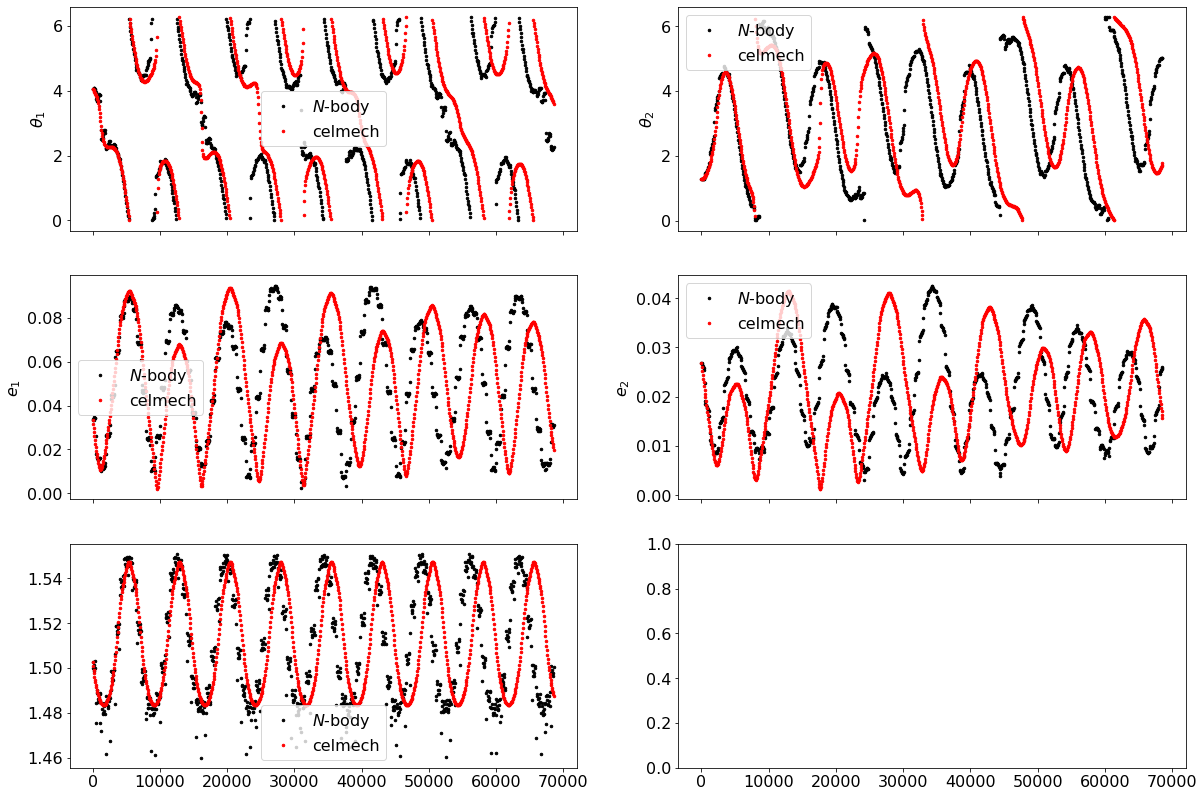

In [11]:
# Plotting:
fig, ((ax_theta1, ax_theta2), (ax_e1, ax_e2), (ax_pr, _ )) = plt.subplots(3, 2, sharex=True, figsize = (20, 14))
# theta1
ax_theta1.plot(times, theta1_rb, 'k.', label = r'$N$-body')
ax_theta1.plot(times, theta1_cm, 'r.', label = r'celmech')
ax_theta1.legend()
ax_theta1.set_ylabel(r'$\theta_1$')
# theta2
ax_theta2.plot(times, theta2_rb, 'k.', label = r'$N$-body')
ax_theta2.plot(times, theta2_cm, 'r.', label = r'celmech')
ax_theta2.legend()
ax_theta2.set_ylabel(r'$\theta_2$')
# e1
ax_e1.plot(times, e1_rb, 'k.', label = r'$N$-body')
ax_e1.plot(times, e1_cm, 'r.', label = r'celmech')
ax_e1.legend()
ax_e1.set_ylabel(r'$e_1$')
# e2
ax_e2.plot(times, e2_rb, 'k.', label = r'$N$-body')
ax_e2.plot(times, e2_cm, 'r.', label = r'celmech')
ax_e2.legend()
ax_e2.set_ylabel(r'$e_2$')
# period ratio
ax_pr.plot(times, pr_rb, 'k.', label = r'$N$-body')
ax_pr.plot(times, pr_cm, 'r.', label = r'celmech')
ax_pr.legend()

## 2.2 A simpler model through canonical transformations

### 2.2.3

Re-create the simulation, this time using only $1$st order MMR terms (still no inclination):

In [12]:
# time_base = np.median(hd_data.BJD)

# make simulation
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
cm.nbody_simulation_utilities.align_simulation(sim)
# convert to poincarehamiltonian
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
pham.add_MMR_terms(3, 1, max_order=1, inclinations=False)
pham.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                  
───── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\
____       _______________ ⎟                                                  
,0}      ╲╱ \Lambda_{1,0}  ⎠                                                  
──────────────────────────── - ───────────────────────────────────────────────
                                                   

create canonical transformation from poincare angles matrix:

In [13]:
import sympy as sp
# defining stuff:

# action variables
# Lambda1, Lambda2, Gamma1, Gamma2, Q1, Q2 = sp.symbols('Lambda_1, Lambda_2, Gamma_1, Gamma_2, Q_1, Q_2')
# old angle coordinates
lambda1, lambda2, pomega1, pomega2, Omega1, Omega2 = sp.symbols('lambda_1, lambda_2, varpi_1, varpi_2, Omega_1, Omega_2')
# new angle coordinates
theta1, theta2, l, psi, phi1, phi2 = sp.symbols('theta_1, theta_2, l, psi, phi_1, phi_2')
p1, p2, L, Psi, Phi1, Phi2 = sp.symbols('p_1, p_2, L, Psi, Phi_1, Phi_2')

# converts
# lambda_1, lambda_2, pomega_1, pomega_2, Omega_1, Omega_2 to
# theta_1, theta_2, l, psi, phi_1, phi_2
pmatrix = [[-2, 3, 1, 0, 0, 0], [-2, 3, 0, 1, 0, 0], [-2, 3, 0, 0, 0, 0], 
           [1, -1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]

ct = cm.CanonicalTransformation.from_poincare_angles_matrix(pvars, pmatrix, 
                                                            new_qp_pairs = [(theta1, p1), (theta2, p2), 
                                                                            (l, L), (psi, Psi), 
                                                                            (phi1, Phi1), (phi2, Phi2)])
ct.old_qp_vars, ct.new_qp_vars

([λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂], [θ₁, θ₂, l, ψ, φ₁, φ₂, p₁, 
p₂, L, Ψ, Φ₁, Φ₂])

Create new Hamiltonian:

In [14]:
new_ham = ct.old_to_new_hamiltonian(pham, do_reduction=True)
new_ham.H

                                                                    ____      
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₁ ⋅cos(θ
- ────────────────────────────────────────────────────────────────────────────
                              _______________                                 
                            ╲╱ \Lambda_{1,0} ⋅a_{2,0}                         

                                                                       ____   
₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₂ ⋅co
── - ─────────────────────────────────────────────────────────────────────────
                                 _______________                              
                               ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      

                  2   2   3                    2   2   3        
s(θ₂)            G ⋅M₁ ⋅μ₁                    G ⋅M₂ ⋅μ₂         
───── - ─────────────────────────── - ──────────────────────────
             

### 2.2.4

Use root-finding method (multivariate Newton's method in this case) to solve for $\dot\theta_i = \dot p_i = 0$. Check the flow and Jacobian of the Hamilotnian given the current values for the qp pairs:

In [15]:
vals = new_ham.values
new_ham.flow_func(*vals).T, new_ham.jacobian_func(*vals)  # transpose flow so it's a row vector

(array([[-5.55439389e-04, -1.92352891e-04, -1.87959981e-09,
         -2.21760762e-09]]),
 array([[ 6.12768695e-04,  0.00000000e+00, -2.70932554e+01,
         -1.78440090e+02],
        [ 0.00000000e+00,  3.53966442e-04, -1.78440090e+02,
         -1.62294404e+02],
        [-1.42400327e-09,  0.00000000e+00, -6.12768695e-04,
          0.00000000e+00],
        [ 0.00000000e+00, -6.33726306e-10,  0.00000000e+00,
         -3.53966442e-04]]))

Coordinate transform $(p, \theta) \to (x, y)$ so Newton's method works:

In [16]:
ctxy = cm.CanonicalTransformation.polar_to_cartesian(new_ham.full_qp_vars,[0,1])
hamxy = ctxy.old_to_new_hamiltonian(new_ham)

Solve for the root using Newton's method:

In [17]:
from scipy.linalg import solve as lin_solve 

y = hamxy.values
fun = lambda x: hamxy.flow_func(*x).reshape(-1)
dfun = lambda x: hamxy.jacobian_func(*x)

# newton's method
def newton_solve(fun,Dfun,guess,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y)
        Df = Dfun(y)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        print("did not converge")
    return y

# solve 
solution = newton_solve(fun, dfun, y)

Compare Newton's method solution to the original values to check that it does result in $\dot x_i = \dot y_i \approx 0$ as required:

In [18]:
fun(y), fun(solution)  # solution is pretty close to 0

(array([ 1.44287208e-06, -9.84168503e-07, -1.27315052e-07,  2.19487059e-07]),
 array([-1.63053842e-20, -2.22346149e-21,  2.42188291e-38,  1.26476108e-37]))

Put these values back into the Hamiltonian, and then convert from $(x, y)$ back to $(p, \theta)$:

In [19]:
hamxy.state.values = solution  # put these values back into the Hamiltonian
# convert all the values of Hamiltonian in the xy coordinates back to theta p coordinates
theta_p_full_values = ctxy.new_to_old_array(hamxy.full_values)
# then put the theta and p values back into the theta p hamiltonian
theta_p_values = np.concatenate((theta_p_full_values[0:2], theta_p_full_values[6:8]))
new_ham.state.values = theta_p_values

And showing that $\dot\theta_i = \dot p_i \approx 0$ in the $(\theta, p)$ coordinates as well by comparing the flow function evaluated at the new values compared to the old ones:

In [20]:
new_ham.flow_func(*vals).T, new_ham.flow_func(*new_ham.values).T  # new values much closer to 0

(array([[-5.55439389e-04, -1.92352891e-04, -1.87959981e-09,
         -2.21760762e-09]]),
 array([[ 1.46475714e-16,  1.53523028e-16,  7.29310702e-41,
         -2.32557395e-25]]))

So the values of $p_1, p_2, \theta_1, \theta_2$ are thus: 

In [21]:
new_ham.values, new_ham.qp_vars

([1.798761455752695e-32, 3.141592653589793, 4.534077009398353e-06, 2.123582709
9578995e-06], [θ₁, θ₂, p₁, p₂])

### 2.2.5

Now turn the Hamiltonian we found at the equilibrium value into a `rebound` simulation. First convert from $(p, \theta)$ back to the default $\eta, \kappa$ variables used by `PoincareHamiltonian` to convert to a `rebound` simulation:

In [22]:
# convert from p, theta back to the default poincare variables
pvars.values = ct.new_to_old_array(new_ham.full_values)
# convert to a rebound simulation
sim_eq = cm.Poincare.to_Simulation(pvars)
inner = sim_eq.particles[1]
outer = sim_eq.particles[2]

Now, compute the time evolution of $\theta_i(t)$ in the `rebound` simulation:

In [23]:
t_end = 3e3
ntimes = 5000

# create times array and empty array to track the resonance angles theta
times_eq = np.linspace(sim_eq.t, sim_eq.t + t_end, ntimes) * inner.P  # 3e3 times the orbital period of the inner planet
theta1_eq, theta2_eq = np.zeros(ntimes), np.zeros(ntimes)

# integrate over times and record theta_1, theta_2
for i,t in enumerate(times_eq):
    sim_eq.integrate(t)  # advance simulation
    # record theta1, theta2
    theta1_eq[i] = np.mod(3 * outer.l - 2 * inner.l - inner.pomega, 2 * np.pi)
    theta2_eq[i] = np.mod(3 * outer.l - 2 * inner.l - outer.pomega, 2 * np.pi)

And plot our results:

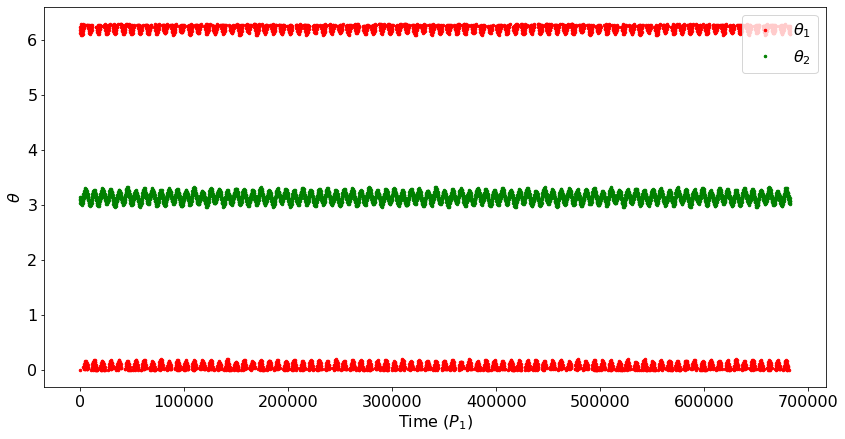

In [24]:
plt.figure(figsize = (14, 7))
plt.plot(times_eq, theta1_eq, 'r.', label = r'$\theta_1$')
plt.plot(times_eq, theta2_eq, 'g.', label = r'$\theta_2$')
plt.xlabel(r'Time $(P_1)$'), plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

The graph visually appears quite close to the actual equilibrium value (taking $\theta \mod 2 \pi$) for $\theta_i$), as expected.

## 3 Dissipative dynamics

Create a new Keplerian Hamiltonian using the equilibrium values from before, adding the interaction terms to first order:

In [25]:
pham_eq = cm.PoincareHamiltonian(pvars)
pham_eq.add_MMR_terms(3, 1, max_order=1, inclinations=False)

Define the equations for $\frac{d\Lambda_i}{dt}$, $\frac{d\eta_i}{dt}$, and $\frac{d\kappa_i}{dt}$:

In [26]:
# symbols

tau_a_1, tau_e_1 = sp.symbols('tau_a_1, tau_e_1')
tau_a_2, tau_e_2 = sp.symbols('tau_a_2, tau_e_2')
Lambda1 = pham_eq.qp_vars[6]
Lambda2 = pham_eq.qp_vars[9]
eta_1 = pham_eq.qp_vars[1]
eta_2 = pham_eq.qp_vars[4]
kappa_1 = pham_eq.qp_vars[7]
kappa_2 = pham_eq.qp_vars[10]
t = sp.symbols('t')

# dLambda, deta, dkappa equations:

dLambda_1 = Lambda1/(2 * tau_a_1)
dLambda_2 = Lambda2/(2 * tau_a_2)

deta_1 = eta_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
deta_2 = eta_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dkappa_1 = kappa_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
dkappa_2 = kappa_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dLambda_1, deta_1, dkappa_1

⎛  Λ₁       ⎛ 1       1   ⎞     ⎛ 1       1   ⎞⎞
⎜──────, η₁⋅⎜──── + ──────⎟, κ₁⋅⎜──── + ──────⎟⎟
⎝2⋅τₐ ₁     ⎝τₑ ₁   4⋅τₐ ₁⎠     ⎝τₑ ₁   4⋅τₐ ₁⎠⎠

Create a matrix for the dissipative terms:

In [27]:
dissipative = sp.zeros(len(pham_eq.values), 1)

# add lambda, eta, kappa dissipative terms
dissipative[6] = dLambda_1
dissipative[9] = dLambda_2

dissipative[1] = deta_1
dissipative[4] = deta_2

dissipative[7] = dkappa_1
dissipative[10] = dkappa_2

Turn the new Hamiltonian plus the dissipative terms into a function for the equations of motion including dissipative terms:

In [28]:
ham_eom = sp.lambdify([t, pham_eq.qp_vars, tau_a_1, tau_a_2, tau_e_1, tau_e_2], dissipative + pham_eq.N_flow)

Define the $\tau_{\alpha_i}$ and $\tau_{e_i}$ values required for the equations of motion:

In [29]:
def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

tau_e_factor = 3
K_test = 10
resonant_period_ratio = 3/2

# use tau_e values of timescale/3

tau_e_1_val, tau_e_2_val = -times[-1]/tau_e_factor, -times[-1]/tau_e_factor
tau_e_val = 1 / (1 / tau_e_1_val + 1 / tau_e_2_val)

tau_a_val = tau_e_val * K_test  # use k = 10

# compute tau_a values

tau_a_1_val, tau_a_2_val = get_tau_alphas(tau_alpha = -tau_a_val, m_inner=inner.m, m_outer = outer.m, period_ratio = resonant_period_ratio)

Use `scipy.integrate.solve_ivp()` with the `DOP853` method to numerically integrate the equations of motion:

In [30]:
from scipy.integrate import solve_ivp

y0 = pham_eq.values
params = (tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val)  # these are the tau_a and tau_e_params as a tuple

# solving the ivp
sols = solve_ivp(lambda t,x: ham_eom(t,x,*params).reshape(-1), [times_eq[0], times_eq[-1]], y0 = y0, dense_output=True, method='DOP853')

Create a simulation using `REBOUND` and `REBOUNDx` (using the earlier `sim_eq` simulation)

In [31]:
sim_eq = cm.Poincare.to_Simulation(pvars)
inner = sim_eq.particles[1]
outer = sim_eq.particles[2]
# reboundx
rebx = reboundx.Extras(sim_eq)
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

inner.params['tau_e'] = tau_e_1_val  # eccentricity damping, these stay constant
outer.params['tau_e'] = tau_e_2_val

outer.params['tau_a'], inner.params['tau_a'] = tau_a_1_val, tau_a_2_val

 Now compare `sim_eq` to the results obtained by numerically integrating over the equations of motion:

In [32]:
from tqdm import tqdm

e_inner_eom = np.zeros(len(sols.y.T))
e_outer_eom = np.zeros(len(sols.y.T))
e_inner_rb, e_outer_rb = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))

p_inner_eom, p_outer_eom = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))
p_inner_rb, p_outer_rb = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))

for i, val in enumerate(sols.y.T):
    pvars.values = val
    e_inner_eom[i] = pvars.particles[1].e
    e_outer_eom[i] = pvars.particles[2].e
    
    p_inner_eom[i] = pvars.particles[1].P
    p_outer_eom[i] = pvars.particles[2].P
    
# for i, t in tqdm(enumerate(sols.t)):
#     sim_eq.integrate(t)
#     e_inner_rb[i] = inner.e
#     e_outer_rb[i] = outer.e
#     p_inner_rb[i] = inner.P
#     p_outer_rb[i] = outer.P

And plot:

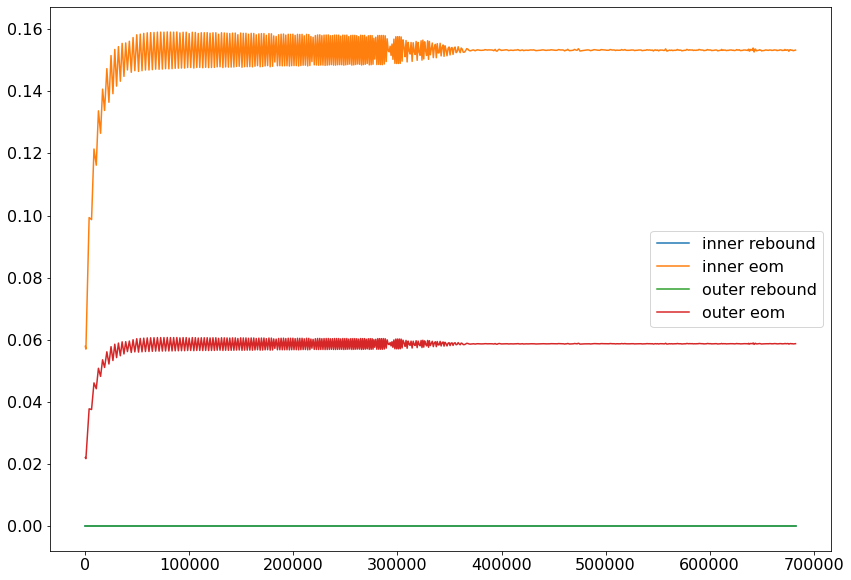

In [33]:
plt.figure(figsize = (14, 10))
plt.plot(sols.t, e_inner_rb, label = 'inner rebound')
plt.plot(sols.t, e_inner_eom, label = 'inner eom')
plt.plot(sols.t, e_outer_rb, label = 'outer rebound')
plt.plot(sols.t, e_outer_eom, label = 'outer eom')
plt.legend()


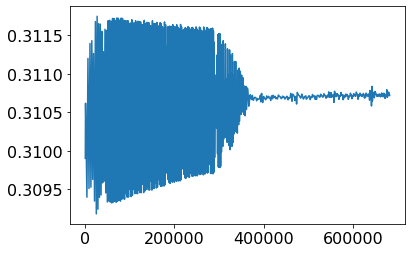

In [34]:
plt.plot(sols.t, sols.y[6]/sols.y[9])

## 3.3 

Add dissipative dynamics to the Hamiltonian from section $2.2$ (using $(p, \theta)$ and express $L$ since it's not conserved:

In [35]:
pham_eq.full_qp_vars, new_ham.full_qp_vars

([λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂], [θ₁, θ₂, l, ψ, φ₁, φ₂, p₁, 
p₂, L, Ψ, Φ₁, Φ₂])

In [36]:
pham_eq.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                  
───── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\
____       _______________ ⎟                                                  
,0}      ╲╱ \Lambda_{1,0}  ⎠                                                  
──────────────────────────── - ───────────────────────────────────────────────
                                                   

In [37]:
[sp.diff(ct.new_to_old(L), var) for var in pham_eq.full_qp_vars]

[0, -η₁, 0, 0, -η₂, 0, 1, -κ₁, 0, 1, -κ₂, 0]

In [38]:
[sp.diff(ct.new_to_old(Psi), var) for var in pham_eq.full_qp_vars]

[0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0]

In [39]:
[sp.diff(ct.new_to_old(theta1), var) for var in pham_eq.qp_vars]

⎡        κ₁                       -η₁               ⎤
⎢-2, ─────────, 0, 3, 0, 0, 0, ─────────, 0, 0, 0, 0⎥
⎢      2     2                   2     2            ⎥
⎣    η₁  + κ₁                  η₁  + κ₁             ⎦

In [40]:
[sp.diff(ct.new_to_old(L), Lambda1)]

[1]

In [41]:
[ct.new_to_old(var) for var in new_ham.full_qp_vars], new_ham.full_qp_vars

⎛⎡                                                                            
⎜⎢                                                                            
⎜⎢-2⋅λ₁ + 3⋅λ₂ + atan2(η₁, κ₁), -2⋅λ₁ + 3⋅λ₂ + atan2(η₂, κ₂), -2⋅λ₁ + 3⋅λ₂, λ₁
⎝⎣                                                                            

                                       2     2    2     2              2     2
                                     η₁    κ₁   η₂    κ₂             η₁    η₂ 
 - λ₂, atan2(ρ₁, σ₁), atan2(ρ₂, σ₂), ─── + ───, ─── + ───, Λ₁ + Λ₂ - ─── - ───
                                      2     2    2     2              2     2 

     2     2                 2     2    2     2⎤                              
   κ₁    κ₂                ρ₁    σ₁   ρ₂    σ₂ ⎥                              
 - ─── - ───, 3⋅Λ₁ + 2⋅Λ₂, ─── + ───, ─── + ───⎥, [θ₁, θ₂, l, ψ, φ₁, φ₂, p₁, p
    2     2                 2     2    2     2 ⎦                              

                ⎞
                ⎟
₂, L, Ψ, Φ₁, 

In [42]:
[sp.diff(ct.new_to_old(theta1), var) for var in pham_eq.qp_vars]

⎡        κ₁                       -η₁               ⎤
⎢-2, ─────────, 0, 3, 0, 0, 0, ─────────, 0, 0, 0, 0⎥
⎢      2     2                   2     2            ⎥
⎣    η₁  + κ₁                  η₁  + κ₁             ⎦

In [43]:
ct_jac = sp.Matrix([[sp.diff(ct.new_to_old(old_var), var) for var in pham_eq.qp_vars] for old_var in new_ham.full_qp_vars])
ct_jac

⎡        κ₁                                                -η₁                
⎢-2  ─────────      0      3       0          0      0  ─────────      0      
⎢      2     2                                            2     2             
⎢    η₁  + κ₁                                           η₁  + κ₁              
⎢                                                                             
⎢                                  κ₂                                         
⎢-2      0          0      3   ─────────      0      0      0          0      
⎢                                2     2                                      
⎢                              η₂  + κ₂                                       
⎢                                                                             
⎢-2      0          0      3       0          0      0      0          0      
⎢                                                                             
⎢1       0          0      -1      0          0     

In [44]:
pham_eq.qp_vars

[λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂]

In [45]:
ct_jac @ (dissipative + pham_eq.N_flow)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [46]:
t = sp.symbols('t')
ham_eom_eq = sp.lambdify([t, pham_eq.full_qp_vars, tau_a_1, tau_a_2, tau_e_1, tau_e_2], ct_jac @ (dissipative + pham_eq.N_flow))

In [47]:
ham_eom_eq(72, y0, tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val)

array([[-9.01561299e-06],
       [-7.62691632e-06],
       [-4.47115912e-04],
       [ 9.35119082e-03],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-3.90525475e-10],
       [-1.92199766e-10],
       [-2.17002156e-08],
       [-4.08042034e-08],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [48]:
from scipy.integrate import solve_ivp

y0 = pham_eq.values
params = (tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val)  # these are the tau_a and tau_e_params as a tuple

# solving the ivp
sols = solve_ivp(lambda t,x: ham_eom_eq(t,x,*params).reshape(-1), [times_eq[0], times_eq[-1]], y0 = y0, dense_output=True, method='DOP853')

In [49]:
sols.t, sols.y.T.shape, times_eq

(array([0.00000000e+00, 3.12810843e-01, 3.44091927e+00, ...,
        3.03357366e+04, 3.03357366e+04, 3.03357366e+04]),
 (5852, 12),
 array([0.00000000e+00, 1.36544541e+02, 2.73089082e+02, ...,
        6.82313073e+05, 6.82449617e+05, 6.82586162e+05]))

In [50]:
pvars.values = sols.y.T[0]
pvars.particles[1].a, pvars.particles[1].e

(0.07957593614296334, 0.15327216044362701)

In [51]:

e_inner_arr = np.zeros(len(sols.y.T))
e_outer_arr = np.zeros(len(sols.y.T))

p_inner_arr = np.zeros(len(sols.y.T))
p_outer_arr = np.zeros(len(sols.y.T))

# e_inner_eom = np.zeros(len(sols.y.T))
# e_outer_eom = np.zeros(len(sols.y.T))
# # e_inner_rb, e_outer_rb = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))

# p_inner_eom, p_outer_eom = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))
# # p_inner_rb, p_outer_rb = np.zeros(len(sols.y.T)), np.zeros(len(sols.y.T))

for i, val in enumerate(sols.y.T):
    # print(i)
    pvars.values = val
    e_inner_arr[i] = pvars.particles[1].e
    e_outer_arr[i] = pvars.particles[2].e
    
    p_inner_arr[i] = pvars.particles[1].P
    p_outer_arr[i] = pvars.particles[2].P
    

AttributeError: sGamma:0.011541290601016805, sLambda:0.003942044894710361, GbyL:2.927742049945576, val:-2.7161894111283713

In [59]:
e_outer_arr

array([0.05873665, 0.05873669, 0.05873712, ..., 0.        , 0.        ,
       0.        ])

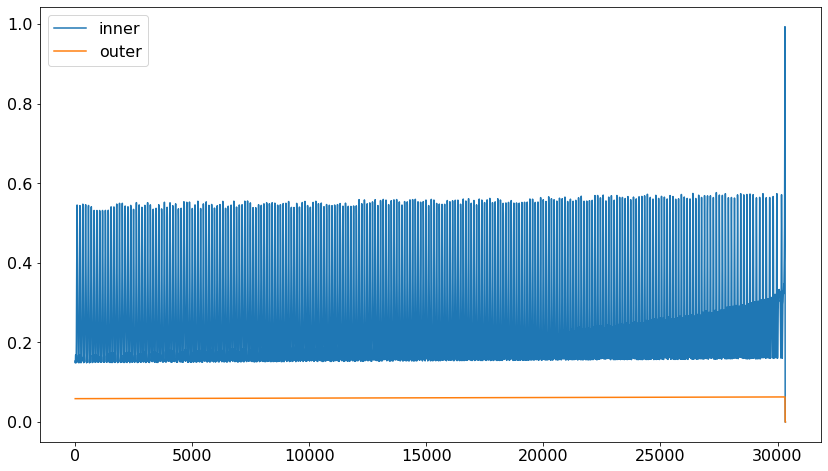

In [58]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, e_inner_arr, label = 'inner')
plt.plot(sols.t, e_outer_arr, label = 'outer')
# plt.xlim(1000,5000)
plt.legend()

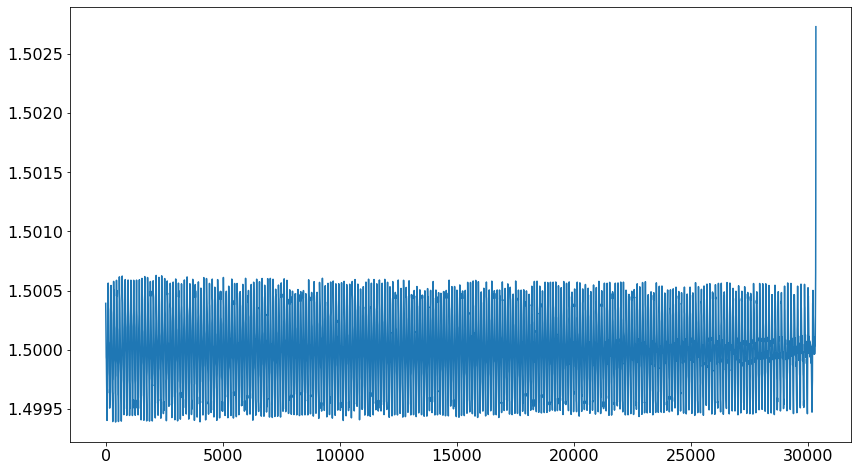

In [54]:
plt.figure(figsize = (14, 8))
plt.plot(sols.t, p_outer_arr/p_inner_arr)